# VASP CdTe benchmark performance

This notebook compares the performance of the VASP CdTe benchmark (hybrid DFT, exact exchange) between ARCHER and various configurations on ARCHER2.

Basic information:
  - Uses `vasp_ncl`
  - `NELM = 6`

Performance summary:
- VASP version:
  + Up to 8 nodes: best performance from VASP 6.3.0
  + 16 nodes or more: best performance from VASP 5.4.4.pl2
- Cores per node:
  + Best performance usually from 128 MPI processes per node - all cores occupied
  + At 64 nodes, best performance from 64 MPI processes per node - 64 cores idle per node
- `NCORE`:
  + Up to 8 nodes: best performance with `NCORE = 4` (VASP 6.3.0)
  + 16 nodes or more: best performance with `NCORE = 16` (VASP 5.4.4.pl2)
- `KPAR = 2` is maximum that can be used on standard memory nodes 
- Scales well to 64 nodes
- Using OpenMP threads results in worse performance

We compute performance using the time for the "LOOP+" cycle as reported by VASP.

Performance is plotted as LOOP+ per second (i.e. inverse of LOOP+ cycle time in seconds).

We have investigated the performance of different versions of VASP and different numerical libraries:

- On ARCHER: Intel Compilers 17, Cray FFTW, Intel MKL 17, Cray MPICH
- On ARCHER2: GCC compilers (v 10.x or 11.x), HPE Cray FFTW 3.3.8.x, HPE Cray MPICH, AOCL or HPE Cray LibSci

## Setup section

Import the required modules and define useful functions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

mpl.rcParams['figure.figsize'] = (12,6)
import seaborn as sns
sns.set(font_scale=1.5, context="paper", style="white", font="serif")
pal = sns.color_palette()
cols = pal.as_hex()

In [2]:
import sys
sys.path.append('../../../python-modules')


In [3]:
from utilities import filemanip, sysinfo
from appanalysis import vasp

In [4]:
sysdetails = sysinfo.getdetails('../../../systems.yaml')

## Process data

In [5]:
results = ['ARCHER', 'ARCHER2-4c_LibSci-20.10',
           'ARCHER2-4c_AOCL-3.0',
           'ARCHER2_VASP544_LibSci-21.04_OFI',
           'ARCHER2_VASP630_AOCL-3.1_OFI',
           'ARCHER2_VASP544_LibSci-21.04_UCX',
           'ARCHER2_VASP630_AOCL-3.1_UCX'
          ]
systems = {
    'ARCHER': 'ARCHER',
    'ARCHER2-4c_LibSci-20.10': 'ARCHER2',
    'ARCHER2-4c_AOCL-3.0': 'ARCHER2',
    'ARCHER2_VASP544_LibSci-21.04_OFI': 'ARCHER2',
    'ARCHER2_VASP630_AOCL-3.1_OFI': 'ARCHER2',
    'ARCHER2_VASP544_LibSci-21.04_UCX': 'ARCHER2',
    'ARCHER2_VASP630_AOCL-3.1_UCX': 'ARCHER2'
    }
perf = {}
notes = {}
names = {}
nodes = {}
cores = {}
perf_nodes = {}
perf_cores = {}
cpn = {}

for res in results:
    wdir = '../CdTe_Hybrid/results/' + res
    filelist = filemanip.get_filelist(wdir, 'CdTe_')
    sysdict = sysdetails[systems[res]]
    names[res] = res
    cpn[res] = sysdict['PCores']*sysdict['PPerNode']
    print('\n============================================================')
    print(res)
    vasp_df = pd.DataFrame(vasp.create_df_list(filelist, sysdict['PCores']*sysdict['PPerNode'], perftype="max"))
    nodes[res], perf_nodes[res] = vasp.get_perf_stats(vasp_df, 'max', writestats=True, plot_cores=False)
    cores[res], perf_cores[res] = vasp.get_perf_stats(vasp_df, 'max', writestats=False, plot_cores=True)
    print('\n============================================================')


ARCHER


/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:144: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)
/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:144: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)


                                                   Perf                      \
                                                    min    median       max   
Nodes Processes Threads Cores NCORE NPAR KPAR                                 
8     192       1       192   8     12   2     0.000080  0.000080  0.000080   
16    384       1       384   8     24   2     0.000153  0.000153  0.000153   
                              24    8    2     0.000124  0.000124  0.000124   
32    768       1       768   8     48   2     0.000269  0.000269  0.000269   
                              48    8    2     0.000118  0.000118  0.000118   
50    1200      1       1200  8     75   2     0.000400  0.000400  0.000400   
64    1536      1       1536  8     96   2     0.000424  0.000424  0.000424   

                                                              LOOP+  \
                                                   mean         min   
Nodes Processes Threads Cores NCORE NPAR KPAR                      

/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:144: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)
/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:144: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)


                                                   Perf                      \
                                                    min    median       max   
Nodes Processes Threads Cores NCORE NPAR KPAR                                 
1     128       1       128   2     32   2     0.000033  0.000033  0.000033   
                              8     8    2     0.000033  0.000033  0.000033   
2     256       1       256   2     64   2     0.000063  0.000063  0.000063   
                              4     32   2     0.000074  0.000074  0.000074   
                              8     16   2     0.000060  0.000065  0.000066   
                              16    8    2     0.000070  0.000070  0.000070   
4     256       1       256   8     16   2     0.000096  0.000096  0.000096   
      512       1       512   2     128  2     0.000110  0.000111  0.000113   
                              4     64   2     0.000133  0.000141  0.000142   
                              8     32   2     0.000

/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:144: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)
/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:144: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)


                                                   Perf                      \
                                                    min    median       max   
Nodes Processes Threads Cores NCORE NPAR KPAR                                 
1     128       1       128   2     32   2     0.000033  0.000033  0.000033   
2     256       1       256   2     64   2     0.000060  0.000060  0.000060   
                              4     32   2     0.000075  0.000075  0.000075   
4     512       1       512   4     64   2     0.000137  0.000137  0.000137   
8     1024      1       1024  4     128  2     0.000115  0.000183  0.000251   
16    2048      1       2048  16    64   2     0.000413  0.000413  0.000413   
32    4096      1       4096  16    128  2     0.000611  0.000611  0.000611   
64    8192      1       8192  16    256  2     0.000665  0.000665  0.000665   

                                                              LOOP+  \
                                                   mean    

/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:144: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)
/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:144: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)


                                                   Perf                      \
                                                    min    median       max   
Nodes Processes Threads Cores NCORE NPAR KPAR                                 
1     64        1       64    2     16   2     0.000037  0.000037  0.000037   
                              4     8    2     0.000035  0.000035  0.000035   
      128       1       128   2     32   2     0.000030  0.000030  0.000030   
                              4     16   2     0.000038  0.000038  0.000038   
2     128       1       128   2     32   2     0.000072  0.000072  0.000072   
                              4     16   2     0.000062  0.000062  0.000062   
                              8     8    2     0.000068  0.000068  0.000068   
      256       1       256   2     64   2     0.000059  0.000059  0.000059   
                              4     32   2     0.000074  0.000074  0.000074   
                              8     16   2     0.000

/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:144: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)
/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:144: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)


                                                   Perf                      \
                                                    min    median       max   
Nodes Processes Threads Cores NCORE NPAR KPAR                                 
1     128       1       128   4     16   2     0.000050  0.000050  0.000050   
2     128       1       128   2     32   2     0.000076  0.000076  0.000076   
                              4     16   2     0.000072  0.000073  0.000073   
                              8     8    2     0.000061  0.000061  0.000061   
      256       1       256   2     64   2     0.000072  0.000073  0.000074   
                              4     32   2     0.000095  0.000095  0.000095   
                              8     16   2     0.000077  0.000078  0.000078   
4     256       1       256   2     64   2     0.000134  0.000135  0.000135   
                              4     32   2     0.000133  0.000133  0.000133   
                              8     16   2     0.000

/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:144: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)
/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:144: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)


                                                   Perf                      \
                                                    min    median       max   
Nodes Processes Threads Cores NCORE NPAR KPAR                                 
1     64        1       64    2     16   2     0.000042  0.000042  0.000042   
                              4     8    2     0.000039  0.000039  0.000039   
      128       1       128   2     32   2     0.000035  0.000035  0.000035   
                              4     16   2     0.000042  0.000043  0.000043   
2     128       1       128   2     32   2     0.000075  0.000077  0.000079   
                              4     16   2     0.000063  0.000064  0.000064   
                              8     8    2     0.000071  0.000071  0.000071   
      256       1       256   2     64   2     0.000064  0.000064  0.000064   
                              4     32   2     0.000081  0.000082  0.000083   
                              8     16   2     0.000

/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:144: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)
/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:144: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)


## Performance Comparison

This plot compares performance for different systems/configurations with respect to "reserved" cores. Reserved cores is defined as the number of nodes multiplied by the total number of cores per node and represents the amount of resource reserved for the run rather than the number of cores used. This is used to be able to compare performance across different systems even when not all cores on a compute node are used.

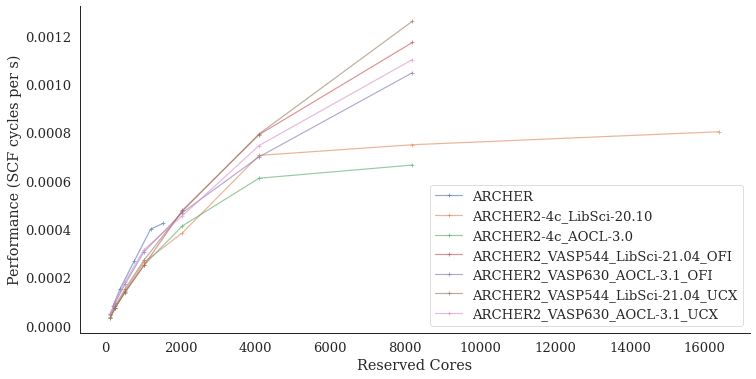

In [6]:
for res in results:
    totcores = [n * cpn[res] for n in nodes[res]]
    plt.plot(totcores, perf_nodes[res], '-+', label=names[res], alpha=0.6)
plt.xlabel('Reserved Cores')
plt.ylabel('Performance (SCF cycles per s)')
plt.legend(loc='best')
sns.despine()
plt.savefig('vasp_cdte_perf.png', dpi=300)